In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import numpy as np

In [3]:
from pathlib import Path
colour = Path('../GTA_images/Simple/Colour')

In [4]:
import sys
sys.path.append('../')

In [5]:
from depth_Functions import import_raw_colour_image, show_img, array_of_images

# Image

## RGB

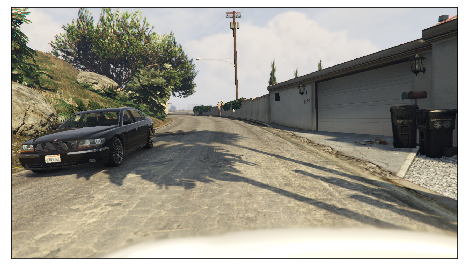

In [17]:
rgb_0 = import_raw_colour_image(list(colour.iterdir())[0])
show_img(rgb_0)

## YCbCR

Convert the image from BGR to YCrCb:
1. Y: Intensity (luminance)
1. Cr: Red difference
1. Cb: Blue difference

In [7]:
ycc_0 = cv2.cvtColor(rgb_0, cv2.COLOR_BGR2YCrCb) 

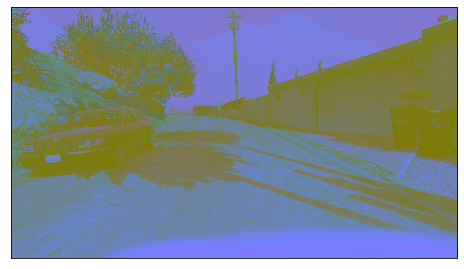

In [15]:
show_img(ycc_0)

# Laws' Mask

[Based on](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect12.pdf)

In [43]:
filters = [
                np.array([1, 4, 6, 4, 2]),
                np.array([-1, -2, 0, 2, 1]),
                np.array([-1, 0, 2, 0, -1]),
                np.array([1, -4, 6, -4, 1])
               ] 
def mask(patch, first, second=None):
    
    
    if second is None:
        return cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[first])
    else:
        filter1 = cv2.filter2D(patch, -1, filters[first].reshape(5,1)*filters[second])
        filter2 = cv2.filter2D(patch, -1, filters[second].reshape(5,1)*filters[first])
        return (filter1 + filter2)/2

def Laws(ycc):
    y, cr, cb = cv2.split(ycc_0)
    level, edge, spot, ripple = 0, 1, 2, 3
    
    masks = [
                mask(y, level, edge),
                mask(y, level, ripple),
                mask(y, edge, spot),
                mask(y, spot),
                mask(y, ripple),
                mask(y, level, spot),
                mask(y, edge),
                mask(y, edge, ripple),
                mask(y, spot, ripple),
                mask(cr, level, edge),
                mask(cb, level, edge)
             ]
    
    return masks

In [44]:
laws = Laws(ycc_0)

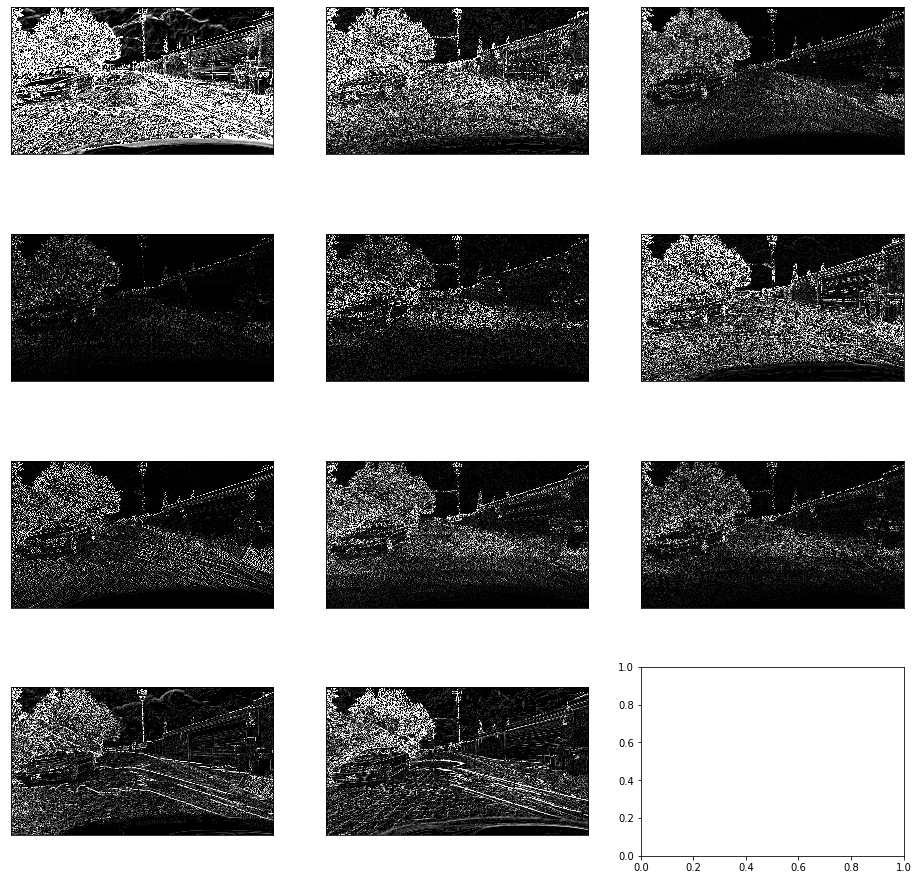

In [45]:
array_of_images(laws, 3, 4)

In [49]:
edges = cv2.Sobel()

In [ ]:
sobel_filters = [
                    np.array([-1,  0,  1], 
                             [-2,  0,  2],
                             [-1,  0,  1]),
                    
                    np.array([ 1,  2,  1],
                             [ 0,  0,  0],
                             [-1, -2, -1])
                ]

In [ ]:
[c-s, 2*s,c+s]
[-2*c, 0, 2*c]
[-s-c, -2*s,s-c]

In [168]:
import math
from scipy import ndimage

def create_kernels(step=90, min=0, max=180):
    kernels = []
    
    for angle in range(min,max,step):
        rad = math.radians(angle)
        cos = round(math.cos(rad),2)
        sin = round(math.sin(rad),2)
        kernels.append(np.array([
                                    [sin-cos, 2*sin, cos+sin],
                                    [-2*cos, 0, 2*cos],
                                    [-sin-cos, -2*sin, cos-sin] 
                                ]))
    
    return kernels

# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_filters(patch, step, min=0, max=180):
    kernels = create_kernels(step=step, min=min, max=max)
    gausian = gaussian_kernel(5)
    gradients = []
    for kernel in kernels:
        gradients.append(ndimage.filters.convolve(patch, kernel))
        
    return gradients
    
# https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def auto_canny(patch, sigma=0.33):
    v = np.median(patch)
    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 - sigma) * v))
    

In [169]:
y, cr, cb = cv2.split(ycc_0)

In [170]:
edges = sobel_filters(y, step=30)

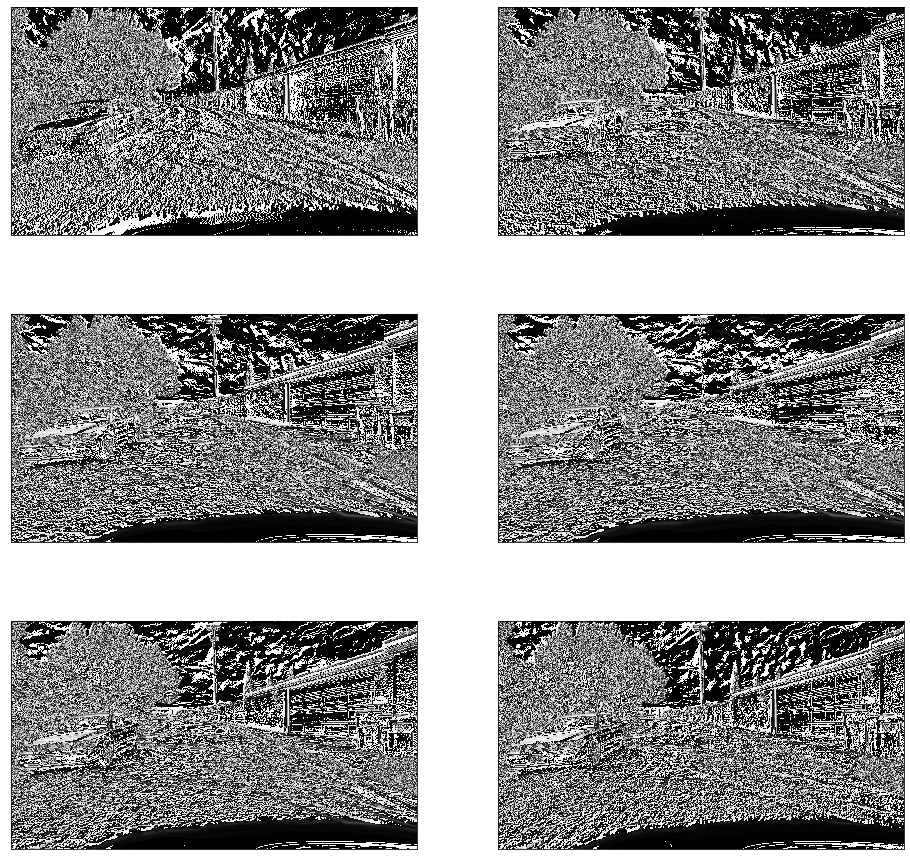

In [182]:
array_of_images(edges, 2, 3)